In [1]:
import os
import json
import numpy as np
from collections import defaultdict
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from datasets import load_dataset #load_dataset from Huggingface
from scipy import stats
from scipy.stats import rankdata, spearmanr, pearsonr
import statsmodels.stats.proportion as smp
from matplotlib.patches import Patch

/opt/homebrew/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
plt.rcParams["savefig.format"] = 'pdf'
plt.rcParams['font.family'] = 'Palatino'

In [7]:
XSTORYCLOZE_LANG_DICT = {'english': 'en', 'chinese': 'zh'}
XSTORYCLOZE_LANGUAGE = ['chinese','english']
XSTORYCLOZE_INPUT_FIELD = ['input_sentence_1', 'input_sentence_2', 'input_sentence_3', 'input_sentence_4', 'sentence_quiz1', 'sentence_quiz2']

XCOPA_LANG_DICT = {'chinese': 'id','englishchinese': 'en_zh'}
XCOPA_INPUT_FIELD = ['premise', 'choice1', 'choice2']
XCOPA_LANGUAGE = ['chinese','englishchinese']

BELEBELE_LANG_DICT = {'simplified chinese': 'zho_Hans', 'english': 'eng_Latn'}
BELEBELE_LANGUAGE = ['simplified chinese', 'english']
BELEBELE_INPUT_FIELD = ['flores_passage']



In [8]:

def get_accuracy_outputs(lang, dataset='xstorycloze', model='Llama3.1'):
    model_dict = {'Llama3.1': 'meta-llama__Llama-3.1-8B'}
    model_code = model_dict[model]

    if dataset=='xstorycloze':
        lang_code = XSTORYCLOZE_LANG_DICT[lang]
        accuracy_data_path = f'../../accuracy_outputs/{model}/{dataset}_unnormalized_5shot/{lang_code}/{model_code}/'
    if dataset=='xcopa':
        lang_code = XCOPA_LANG_DICT[lang]
        accuracy_data_path = f'../../accuracy_outputs/{model}/{dataset}_unnormalized_5shot/{lang_code}/{model_code}/'
    if dataset=='belebele':
        lang_code=BELEBELE_LANG_DICT[lang]
        accuracy_data_path = f'../../accuracy_outputs/{model}/{dataset}_5shot/{lang_code}/'

    # Find the .jsonl file in the directory
    jsonl_file = [f for f in os.listdir(accuracy_data_path) if f.endswith('.jsonl')][0]
    file_path = os.path.join(accuracy_data_path, jsonl_file)
    # Read the jsonl file line by line
    accuracy_results = []
    with open(file_path, 'r') as f:
        for line in f:
            accuracy_results.append(json.loads(line))
    
    accuracy = [item['acc'] for item in accuracy_results]
    return  accuracy

In [9]:
def get_xstorycloze_alignment(lang, model, mode):
    if mode == 'DALI':
        DAS_path = f'../../alignment_outputs/{model}/xstorycloze_dali/BAS_{lang}_lasttoken.json'
        with open(DAS_path) as f:
            lang_DAS = json.load(f)
        lang_DAS = {int(outer_k): {int(inner_k): v for inner_k, v in inner_v.items()} 
                for outer_k, inner_v in lang_DAS.items()}
        
    if mode == 'DALIStrong':
        DAS_path = f'../../alignment_outputs/{model}/xstorycloze_dali_strong/DALI_{lang}_lasttoken.json'
        with open(DAS_path) as f:
            lang_DAS = json.load(f)
        lang_DAS = {int(outer_k): {int(inner_k): v for inner_k, v in inner_v.items()} 
                for outer_k, inner_v in lang_DAS.items()}


    if mode == 'MEXAFlores':
        flores_dict = {'chinese': 'zho_Hans'}        
        lang_code = flores_dict[lang]
        DAS_path = f'../../alignment_outputs/{model}/flores_mexa/{lang_code}.json'
        with open(DAS_path) as f:
            lang_DAS_raw = json.load(f)
        lang_DAS_raw = {int(k): v for k,v in lang_DAS_raw.items()}
        lang_DAS = defaultdict(dict)
        for layer in range(32):
            for i,dali in enumerate(lang_DAS_raw[layer]):
                lang_DAS[i][layer] = lang_DAS_raw[layer][i]
                
    if mode == 'MEXATask':
        DAS_path = f'../../alignment_outputs/{model}/xstorycloze_mexa/{lang}.json'
        with open(DAS_path) as f:
            lang_DAS_raw = json.load(f)
        lang_DAS_raw = {int(k): v for k,v in lang_DAS_raw.items()}
        lang_DAS = defaultdict(dict)
        for layer in range(32):
            for i,dali in enumerate(lang_DAS_raw[layer]):
                lang_DAS[i][layer] = lang_DAS_raw[layer][i]
    
    return lang_DAS

In [10]:
def get_xcopa_alignment(lang, model, mode):
    if mode == 'DALI':
        DAS_path = f'../../alignment_outputs/{model}/xcopa_dali/DALI_{lang}_lasttoken.json'
        with open(DAS_path) as f:
            lang_DAS = json.load(f)
        lang_DAS = {int(outer_k): {int(inner_k): v for inner_k, v in inner_v.items()} 
                for outer_k, inner_v in lang_DAS.items()}
        
    if mode == 'DALIStrong':
        DAS_path = f'../../alignment_outputs/{model}/xcopa_dali_strong/DALI_{lang}_lasttoken.json'
        with open(DAS_path) as f:
            lang_DAS = json.load(f)
        lang_DAS = {int(outer_k): {int(inner_k): v for inner_k, v in inner_v.items()} 
                for outer_k, inner_v in lang_DAS.items()}


    if mode == 'MEXAFlores':
        flores_dict = {'chinese': 'zho_Hans'}        
        lang_code = flores_dict[lang]
        DAS_path = f'../../alignment_outputs/{model}/flores_mexa/{lang_code}.json'
        with open(DAS_path) as f:
            lang_DAS_raw = json.load(f)
        lang_DAS_raw = {int(k): v for k,v in lang_DAS_raw.items()}
        lang_DAS = defaultdict(dict)
        for layer in range(32):
            for i,dali in enumerate(lang_DAS_raw[layer]):
                lang_DAS[i][layer] = lang_DAS_raw[layer][i]
                
    if mode == 'MEXATask':
        DAS_path = f'../../alignment_outputs/{model}/xcopa_mexa/{lang}.json'
        with open(DAS_path) as f:
            lang_DAS_raw = json.load(f)
        lang_DAS_raw = {int(k): v for k,v in lang_DAS_raw.items()}
        lang_DAS = defaultdict(dict)
        for layer in range(32):
            for i,dali in enumerate(lang_DAS_raw[layer]):
                lang_DAS[i][layer] = lang_DAS_raw[layer][i]
    
    return lang_DAS

In [11]:
def get_belebele_alignment(lang, model, mode):
    if mode == 'DALI':
        DAS_path = f'../../alignment_outputs/{model}/belebele_dali/DALI_{lang}_lasttoken.json'
        with open(DAS_path) as f:
            lang_DAS = json.load(f)
        lang_DAS = {int(outer_k)-1: {int(inner_k): v for inner_k, v in inner_v.items()} 
                for outer_k, inner_v in lang_DAS.items()}
        
    if mode == 'DALIStrong':
        DAS_path = f'../../alignment_outputs/{model}/belebele_dali_strong/DALI_{lang}_lasttoken.json'
        with open(DAS_path) as f:
            lang_DAS = json.load(f)
        lang_DAS = {int(outer_k)-1: {int(inner_k): v for inner_k, v in inner_v.items()} 
                for outer_k, inner_v in lang_DAS.items()}


    if mode == 'MEXAFlores':
        flores_dict = {'chinese': 'zho_Hans'}        
        lang_code = flores_dict[lang]
        DAS_path = f'../../alignment_outputs/{model}/flores_mexa/{lang_code}.json'
        with open(DAS_path) as f:
            lang_DAS_raw = json.load(f)
        lang_DAS_raw = {int(k): v for k,v in lang_DAS_raw.items()}
        lang_DAS = defaultdict(dict)
        for layer in range(32):
            for i,dali in enumerate(lang_DAS_raw[layer]):
                lang_DAS[i][layer] = lang_DAS_raw[layer][i]
                
    if mode == 'MEXATask':
        DAS_path = f'../../alignment_outputs/{model}/belebele_mexa/{lang}.json'
        with open(DAS_path) as f:
            lang_DAS_raw = json.load(f)
        lang_DAS_raw = {int(k): v for k,v in lang_DAS_raw.items()}
        lang_DAS = defaultdict(dict)
        for layer in range(32):
            for i,dali in enumerate(lang_DAS_raw[layer]):
                lang_DAS[i][layer] = lang_DAS_raw[layer][i]
    
    return lang_DAS
    

In [12]:
xstorycloze_acc = defaultdict()
xcopa_acc = defaultdict()
belebele_acc = defaultdict()

for lang in XSTORYCLOZE_LANGUAGE:
    xstorycloze_acc[lang] = get_accuracy_outputs(lang, 'xstorycloze', model='Llama3.1')
for lang in XCOPA_LANGUAGE:
    xcopa_acc[lang] = get_accuracy_outputs(lang, 'xcopa', model='Llama3.1')
for lang in BELEBELE_LANGUAGE:
    belebele_acc[lang] = get_accuracy_outputs(lang, 'belebele', model='Llama3.1')


In [13]:
def get_cc_cw_idx(dataset, acc_dict):
    if dataset == 'xstorycloze':
        correct_id_eng = [i for i,acc in enumerate(acc_dict['english']) if acc==1]
        correct_id_zh = [i for i,acc in enumerate(acc_dict['chinese']) if acc==1]
        incorrect_id_zh = [i for i,acc in enumerate(acc_dict['chinese']) if acc==0]

    if dataset == 'xcopa':
        correct_id_eng = [i for i,acc in enumerate(acc_dict['englishchinese']) if acc==1]
        correct_id_zh = [i for i,acc in enumerate(acc_dict['chinese']) if acc==1]
        incorrect_id_zh = [i for i,acc in enumerate(acc_dict['chinese']) if acc==0]

    if dataset == 'belebele':
        correct_id_eng = [i for i,acc in enumerate(acc_dict['english']) if acc==1]
        correct_id_zh = [i for i,acc in enumerate(acc_dict['simplified chinese']) if acc==1]
        incorrect_id_zh = [i for i,acc in enumerate(acc_dict['simplified chinese']) if acc==0]

    cc_idx = list(set(correct_id_eng) & set(correct_id_zh))
    cw_idx = list(set(correct_id_eng) & set(incorrect_id_zh))

    return cc_idx, cw_idx    

In [14]:
def load_translation_sample(dataset, model, field):
    entoxxpath = f'../../translation_outputs/{model}/{dataset}/{field}/entoxx_{model}_{dataset}_COMET_sample.json'
    xxtoenpath = f'../../translation_outputs/{model}/{dataset}/{field}/xxtoen_{model}_{dataset}_COMET_sample.json'

    with open(entoxxpath) as f:
        entoxx_COMET_sample = json.load(f)
    with open(xxtoenpath) as f:
        xxtoen_COMET_sample = json.load(f)
    
    if dataset =='xstorycloze':
        return entoxx_COMET_sample['chinese']['scores'], xxtoen_COMET_sample['chinese']['scores']
    
    if dataset == 'xcopa':
        return entoxx_COMET_sample['chinese']['scores'], xxtoen_COMET_sample['chinese']['scores']
    
    if dataset == 'belebele':
        return entoxx_COMET_sample['simplified chinese']['scores'], xxtoen_COMET_sample['simplified chinese']['scores']

    

In [15]:
xstorycloze_cc_idx, xstorycloze_cw_idx = get_cc_cw_idx('xstorycloze', xstorycloze_acc)
xcopa_cc_idx, xcopa_cw_idx = get_cc_cw_idx('xcopa', xcopa_acc)
belebele_cc_idx, belebele_cw_idx = get_cc_cw_idx('belebele', belebele_acc)

In [16]:
#Get sample level metrics for dali, dalistrong, mexatask, and mexaflores

xstorycloze_dali = get_xstorycloze_alignment(lang='chinese', model='Llama3.1', mode='DALI')
xstorycloze_dalistrong = get_xstorycloze_alignment(lang='chinese', model='Llama3.1', mode='DALIStrong')
xstorycloze_mexa = get_xstorycloze_alignment(lang='chinese', model='Llama3.1', mode='MEXATask')

xcopa_dali = get_xcopa_alignment(lang='chinese', model='Llama3.1', mode='DALI')
xcopa_dalistrong = get_xcopa_alignment(lang='chinese', model='Llama3.1', mode='DALIStrong')
xcopa_mexa = get_xcopa_alignment(lang='chinese', model='Llama3.1', mode='MEXATask')

belebele_dali = get_belebele_alignment(lang='zho_Hans', model='Llama3.1', mode='DALI')
belebele_dalistrong = get_belebele_alignment(lang='zho_Hans', model='Llama3.1', mode='DALIStrong')
belebele_mexa = get_belebele_alignment(lang='zho_Hans', model='Llama3.1', mode='MEXATask')

#Can use any get-alignment functions
flores_mexa = get_xstorycloze_alignment(lang='chinese', model='Llama3.1', mode='MEXAFlores')

In [17]:

xstorycloze_entoxx_sample = defaultdict(dict)
xstorycloze_xxtoen_sample = defaultdict(dict)

xcopa_entoxx_sample = defaultdict(dict)
xcopa_xxtoen_sample = defaultdict(dict)

for field in XSTORYCLOZE_INPUT_FIELD:
    xstorycloze_entoxx_sample[field], xstorycloze_xxtoen_sample[field] = load_translation_sample('xstorycloze', 'Llama3.1', field)

for field in XCOPA_INPUT_FIELD:
    xcopa_entoxx_sample[field], xcopa_xxtoen_sample[field] = load_translation_sample('xcopa', 'Llama3.1', field)

belebele_entoxx_sample, belebele_xxtoen_sample = load_translation_sample('belebele', 'Llama3.1', 'flores_passage')

In [18]:
#Take the mean across all input fields for xstorycloze and xcopa

xstorycloze_entoxx_sample_formatted = [np.mean([xstorycloze_entoxx_sample[field][i] for field in XSTORYCLOZE_INPUT_FIELD]) for i in range(1511)]
xstorycloze_xxtoen_sample_formatted = [np.mean([xstorycloze_xxtoen_sample[field][i] for field in XSTORYCLOZE_INPUT_FIELD]) for i in range(1511)]

xcopa_entoxx_sample_formatted = [np.mean([xcopa_entoxx_sample[field][i] for field in XCOPA_INPUT_FIELD]) for i in range(500)]
xcopa_xxtoen_sample_formatted = [np.mean([xcopa_xxtoen_sample[field][i] for field in XCOPA_INPUT_FIELD]) for i in range(500)]

In [19]:
# Get sample level translation outputs

xstorycloze_entoxx_cc_mean = np.mean([xstorycloze_entoxx_sample_formatted[i] for i in xstorycloze_cc_idx])
xstorycloze_entoxx_cw_mean = np.mean([xstorycloze_entoxx_sample_formatted[i] for i in xstorycloze_cw_idx])


xcopa_entoxx_cc_mean = np.mean([xcopa_entoxx_sample_formatted[i] for i in xcopa_cc_idx])
xcopa_entoxx_cw_mean = np.mean([xcopa_entoxx_sample_formatted[i] for i in xcopa_cw_idx])

belebele_entoxx_cc_mean = np.mean([belebele_entoxx_sample[i] for i in belebele_cc_idx])
belebele_entoxx_cw_mean = np.mean([belebele_entoxx_sample[i] for i in belebele_cw_idx])

xstorycloze_xxtoen_cc_mean = np.mean([xstorycloze_xxtoen_sample_formatted[i] for i in xstorycloze_cc_idx])
xstorycloze_xxtoen_cw_mean = np.mean([xstorycloze_xxtoen_sample_formatted[i] for i in xstorycloze_cw_idx])

xcopa_xxtoen_cc_mean = np.mean([xcopa_xxtoen_sample_formatted[i] for i in xcopa_cc_idx])
xcopa_xxtoen_cw_mean = np.mean([xcopa_xxtoen_sample_formatted[i] for i in xcopa_cw_idx])

belebele_xxtoen_cc_mean = np.mean([belebele_xxtoen_sample[i] for i in belebele_cc_idx])
belebele_xxtoen_cw_mean = np.mean([belebele_xxtoen_sample[i] for i in belebele_cw_idx])


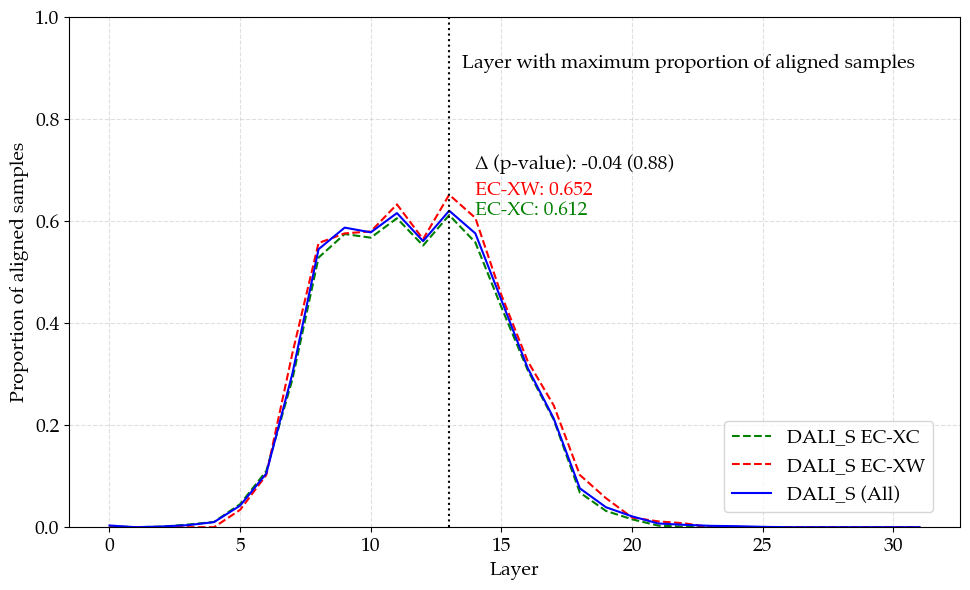

In [ ]:
#Xstorycloze alignment plots

xstorycloze_dali_all_list = defaultdict(list)
xstorycloze_dali_all_mean = []

xstorycloze_dali_cc_list = defaultdict(list)
xstorycloze_dali_cc_mean = []
xstorycloze_dali_cw_list = defaultdict(list)
xstorycloze_dali_cw_mean = []

xstorycloze_dalistrong_all_list = defaultdict(list)
xstorycloze_dalistrong_all_mean = []
xstorycloze_dalistrong_cc_list = defaultdict(list)
xstorycloze_dalistrong_cc_mean = []
xstorycloze_dalistrong_cw_list = defaultdict(list)
xstorycloze_dalistrong_cw_mean = []

xstorycloze_mexa_all_list = defaultdict(list)
xstorycloze_mexa_all_mean = []
xstorycloze_mexa_cc_list = defaultdict(list)
xstorycloze_mexa_cw_list = defaultdict(list)
xstorycloze_mexa_cc_mean = []
xstorycloze_mexa_cw_mean = []


for i in range(1511):
    for j in range(32):
        xstorycloze_dali_all_list[j].append(xstorycloze_dali[i][j])
        xstorycloze_dalistrong_all_list[j].append(xstorycloze_dalistrong[i][j])
        xstorycloze_mexa_all_list[j].append(xstorycloze_mexa[i][j])


for i in xstorycloze_cc_idx:
    for j in range(32):
        xstorycloze_dali_cc_list[j].append(xstorycloze_dali[i][j])
        xstorycloze_dalistrong_cc_list[j].append(xstorycloze_dalistrong[i][j])
        xstorycloze_mexa_cc_list[j].append(xstorycloze_mexa[i][j])

for i in xstorycloze_cw_idx:
    for j in range(32):
        xstorycloze_dali_cw_list[j].append(xstorycloze_dali[i][j])
        xstorycloze_dalistrong_cw_list[j].append(xstorycloze_dalistrong[i][j])
        xstorycloze_mexa_cw_list[j].append(xstorycloze_mexa[i][j])


#All
for k,v in xstorycloze_dali_all_list.items():
    xstorycloze_dali_all_mean.append(np.mean(v))

xstorycloze_dali_max_idx = np.argmax(xstorycloze_dali_all_mean)

for k,v in xstorycloze_dalistrong_all_list.items():
    xstorycloze_dalistrong_all_mean.append(np.mean(v))

xstorycloze_dalistrong_max_idx = np.argmax(xstorycloze_dalistrong_all_mean)

for k,v in xstorycloze_mexa_all_list.items():
    xstorycloze_mexa_all_mean.append(np.mean(v))

xstorycloze_mexa_max_idx = np.argmax(xstorycloze_mexa_all_mean)


#CC
for k,v in xstorycloze_dali_cc_list.items():
    xstorycloze_dali_cc_mean.append(np.mean(v))


for k,v in xstorycloze_dalistrong_cc_list.items():
    xstorycloze_dalistrong_cc_mean.append(np.mean(v))

for k,v in xstorycloze_mexa_cc_list.items():
    xstorycloze_mexa_cc_mean.append(np.mean(v))

#CW
for k,v in xstorycloze_dali_cw_list.items():
    xstorycloze_dali_cw_mean.append(np.mean(v))

for k,v in xstorycloze_dalistrong_cw_list.items():
    xstorycloze_dalistrong_cw_mean.append(np.mean(v))

for k,v in xstorycloze_mexa_cw_list.items():
    xstorycloze_mexa_cw_mean.append(np.mean(v))


plt.rcParams['font.family'] = 'Palatino'
plt.figure(figsize=(10, 6))


# Plot lines for each alignment metric
plt.plot(range(32), xstorycloze_dalistrong_cc_mean, color='green', linestyle='--', label='DALI_S EC-XC', markersize=1)
plt.plot(range(32), xstorycloze_dalistrong_cw_mean, color='red', linestyle='--', label='DALI_S EC-XW',markersize=1)
plt.plot(range(32), xstorycloze_dalistrong_all_mean, color='blue', linestyle='-', label='DALI_S (All)', markersize=1)
plt.vlines(xstorycloze_dalistrong_max_idx, colors="black", linestyles='dotted',ymin=0,ymax=1)





delta=xstorycloze_dalistrong_cc_mean[xstorycloze_dalistrong_max_idx]-xstorycloze_dalistrong_cw_mean[xstorycloze_dalistrong_max_idx]
count = [np.sum(xstorycloze_dalistrong_cc_list[xstorycloze_dalistrong_max_idx]), np.sum(xstorycloze_dalistrong_cw_list[xstorycloze_dalistrong_max_idx])]
nobs = [len(xstorycloze_dalistrong_cc_list[xstorycloze_dalistrong_max_idx]), len(xstorycloze_dalistrong_cw_list[xstorycloze_dalistrong_max_idx])]
stat, pval = smp.proportions_ztest(count, nobs, alternative="larger")


plt.xlabel('Layer',size=14)
plt.ylabel('Proportion of aligned samples',size=14)
plt.yticks(size=14)
plt.xticks(size=14)
plt.ylim(0,1)
#plt.title('XStoryCloze ')
plt.grid(True, linestyle='--', alpha=0.4)
# Position legend at bottom right
plt.legend(loc='lower right', bbox_to_anchor=(0.98, 0.01), ncol=1, fontsize=14)
plt.text(xstorycloze_dalistrong_max_idx+0.5,0.9,"Layer with maximum proportion of aligned samples", size=14)
plt.text(xstorycloze_dalistrong_max_idx+1,
         xstorycloze_dalistrong_cc_mean[xstorycloze_dalistrong_max_idx],
         f"EC-XC: {xstorycloze_dalistrong_cc_mean[xstorycloze_dalistrong_max_idx]:.3f}",color="green", size=14)

plt.text(xstorycloze_dalistrong_max_idx+1,
         xstorycloze_dalistrong_cw_mean[xstorycloze_dalistrong_max_idx],
         f"EC-XW: {xstorycloze_dalistrong_cw_mean[xstorycloze_dalistrong_max_idx]:.3f}",color="red", size=14)

plt.text(xstorycloze_dalistrong_max_idx+1,
         xstorycloze_dalistrong_cw_mean[xstorycloze_dalistrong_max_idx]+0.05,
         f"Δ (p-value): {delta:.2f} ({pval:.2f})",color="black", size=14)


plt.tight_layout()
plt.savefig(fname='../../../../Images_DALI/xstorycloze_plots/experiment_illustrated')
plt.show()







In [ ]:
#XCOPA alignment plots

xcopa_dali_all_list = defaultdict(list)
xcopa_dalistrong_all_list = defaultdict(list)
xcopa_mexa_all_list = defaultdict(list)
xcopa_dali_all_mean = []
xcopa_dalistrong_all_mean = []
xcopa_mexa_all_mean = []



xcopa_dali_cc_list = defaultdict(list)
xcopa_dali_cc_mean = []
xcopa_dali_cw_list = defaultdict(list)
xcopa_dali_cw_mean = []

xcopa_dalistrong_cc_list = defaultdict(list)
xcopa_dalistrong_cc_mean = []
xcopa_dalistrong_cw_list = defaultdict(list)
xcopa_dalistrong_cw_mean = []

xcopa_mexa_cc_list = defaultdict(list)
xcopa_mexa_cw_list = defaultdict(list)
xcopa_mexa_cc_mean = []
xcopa_mexa_cw_mean = []



for i in range(500):
    for j in range(32):
        xcopa_dali_all_list[j].append(xcopa_dali[i][j])
        xcopa_dalistrong_all_list[j].append(xcopa_dalistrong[i][j])
        xcopa_mexa_all_list[j].append(xcopa_mexa[i][j])

for i in xcopa_cc_idx:
    for j in range(32):
        xcopa_dali_cc_list[j].append(xcopa_dali[i][j])
        xcopa_dalistrong_cc_list[j].append(xcopa_dalistrong[i][j])
        xcopa_mexa_cc_list[j].append(xcopa_mexa[i][j])

for i in xcopa_cw_idx:
    for j in range(32):
        xcopa_dali_cw_list[j].append(xcopa_dali[i][j])
        xcopa_dalistrong_cw_list[j].append(xcopa_dalistrong[i][j])
        xcopa_mexa_cw_list[j].append(xcopa_mexa[i][j])


#All

for k,v in xcopa_dali_all_list.items():
    xcopa_dali_all_mean.append(np.mean(v))

for k,v in xcopa_dalistrong_all_list.items():
    xcopa_dalistrong_all_mean.append(np.mean(v))

for k,v in xcopa_mexa_all_list.items():
    xcopa_mexa_all_mean.append(np.mean(v))

xcopa_dali_max_idx = np.argmax(xcopa_dali_all_mean)
xcopa_dalistrong_max_idx = np.argmax(xcopa_dalistrong_all_mean)
xcopa_mexa_max_idx = np.argmax(xcopa_mexa_all_mean)


#CC
for k,v in xcopa_dali_cc_list.items():
    xcopa_dali_cc_mean.append(np.mean(v))

for k,v in xcopa_dalistrong_cc_list.items():
    xcopa_dalistrong_cc_mean.append(np.mean(v))

for k,v in xcopa_mexa_cc_list.items():
    xcopa_mexa_cc_mean.append(np.mean(v))

#CW
for k,v in xcopa_dali_cw_list.items():
    xcopa_dali_cw_mean.append(np.mean(v))

for k,v in xcopa_dalistrong_cw_list.items():
    xcopa_dalistrong_cw_mean.append(np.mean(v))

for k,v in xcopa_mexa_cw_list.items():
    xcopa_mexa_cw_mean.append(np.mean(v))




"  \nplt.rcParams['font.family'] = 'Palatino'\nplt.figure(figsize=(10, 6))\n\n\n# Plot lines for each alignment metric\nplt.plot(range(32), xcopa_dali_cc_mean, marker='^', color='green',linestyle='-.', label='DALI CC')\nplt.plot(range(32), xcopa_dali_cw_mean, marker='^', color='purple',linestyle='-.', label='DALI CW')\nplt.plot(range(32), xcopa_dalistrong_cc_mean, marker='s', color='green', linestyle='--', label='DALIStrong CC')\nplt.plot(range(32), xcopa_dalistrong_cw_mean, marker='s', color='purple', linestyle='--', label='DALIStrong CW')\n\nplt.plot(range(32), xcopa_mexa_cc_mean, marker='o', color='green', linestyle='-', label='MEXATask CC')\nplt.plot(range(32), xcopa_mexa_cw_mean, marker='o', color='purple', linestyle='-', label='MEXATask CW')\n\n\n\n\n#plt.hlines(y=xcopa_xxtoen_cc_mean, xmin=1, xmax=30, color='green', label='XXtoEn (CC)', linestyles='dashed')\n#plt.hlines(y=xcopa_entoxx_cc_mean, xmin=1, xmax=30,color='green', label='EntoXX (CC)', linestyles='dotted')\n\n#plt.hline

In [22]:
#Belebele alignment plots

belebele_dali_all_list = defaultdict(list)
belebele_dalistrong_all_list = defaultdict(list)
belebele_mexa_all_list = defaultdict(list)
belebele_dali_all_mean = []
belebele_dalistrong_all_mean = []
belebele_mexa_all_mean = []


belebele_dali_cc_list = defaultdict(list)
belebele_dali_cc_mean = []
belebele_dali_cw_list = defaultdict(list)
belebele_dali_cw_mean = []

belebele_dalistrong_cc_list = defaultdict(list)
belebele_dalistrong_cc_mean = []
belebele_dalistrong_cw_list = defaultdict(list)
belebele_dalistrong_cw_mean = []

belebele_mexa_cc_list = defaultdict(list)
belebele_mexa_cw_list = defaultdict(list)
belebele_mexa_cc_mean = []
belebele_mexa_cw_mean = []


for i in range(900):
    for j in range(32):
        belebele_dali_all_list[j].append(belebele_dali[i][j])
        belebele_dalistrong_all_list[j].append(belebele_dalistrong[i][j])
        belebele_mexa_all_list[j].append(belebele_mexa[i][j])



for i in belebele_cc_idx:
    for j in range(32):
        belebele_dali_cc_list[j].append(belebele_dali[i][j])
        belebele_dalistrong_cc_list[j].append(belebele_dalistrong[i][j])
        belebele_mexa_cc_list[j].append(belebele_mexa[i][j])

for i in belebele_cw_idx:
    for j in range(32):
        belebele_dali_cw_list[j].append(belebele_dali[i][j])
        belebele_dalistrong_cw_list[j].append(belebele_dalistrong[i][j])
        belebele_mexa_cw_list[j].append(belebele_mexa[i][j])


#All
for k,v in belebele_dali_all_list.items():
    belebele_dali_all_mean.append(np.mean(v))

for k,v in belebele_dalistrong_all_list.items():
    belebele_dalistrong_all_mean.append(np.mean(v))

for k,v in belebele_mexa_all_list.items():
    belebele_mexa_all_mean.append(np.mean(v))

belebele_dali_max_idx = np.argmax(belebele_dali_all_mean)
belebele_dalistrong_max_idx = np.argmax(belebele_dalistrong_all_mean)
belebele_mexa_max_idx = np.argmax(belebele_mexa_all_mean)


#CC
for k,v in belebele_dali_cc_list.items():
    belebele_dali_cc_mean.append(np.mean(v))

for k,v in belebele_dalistrong_cc_list.items():
    belebele_dalistrong_cc_mean.append(np.mean(v))

for k,v in belebele_mexa_cc_list.items():
    belebele_mexa_cc_mean.append(np.mean(v))

#CW
for k,v in belebele_dali_cw_list.items():
    belebele_dali_cw_mean.append(np.mean(v))

for k,v in belebele_dalistrong_cw_list.items():
    belebele_dalistrong_cw_mean.append(np.mean(v))

for k,v in belebele_mexa_cw_list.items():
    belebele_mexa_cw_mean.append(np.mean(v))

In [23]:
# Data for plotting
categories = ['DALIStrong CW', 'DALIStrong CC', 'DALI CW', 'DALI CC', 'MEXA CW', 'MEXA CC']
belebele_values = [
    belebele_dalistrong_cw_mean[belebele_dalistrong_max_idx] * 100,
    belebele_dalistrong_cc_mean[belebele_dalistrong_max_idx] * 100,
    belebele_dali_cw_mean[belebele_dali_max_idx] * 100,
    belebele_dali_cc_mean[belebele_dali_max_idx] * 100,
    belebele_mexa_cw_mean[belebele_mexa_max_idx] * 100,
    belebele_mexa_cc_mean[belebele_mexa_max_idx] * 100
]


count = [np.sum(belebele_dali_cc_list[belebele_dali_max_idx]), np.sum(belebele_dali_cw_list[belebele_dali_max_idx])]
nobs = [len(belebele_dali_cc_list[belebele_dali_max_idx]), len(belebele_dali_cw_list[belebele_dali_max_idx])]
stat, pval = smp.proportions_ztest(count, nobs, alternative="larger")
belebele_annotation_text_dali = f'Δ: {(belebele_dali_cc_mean[belebele_dali_max_idx]-belebele_dali_cw_mean[belebele_dali_max_idx])*100:.2f}%\np-value: {pval:.3f}'

count = [np.sum(belebele_dalistrong_cc_list[belebele_dalistrong_max_idx]), np.sum(belebele_dalistrong_cw_list[belebele_dalistrong_max_idx])]
nobs = [len(belebele_dalistrong_cc_list[belebele_dalistrong_max_idx]), len(belebele_dalistrong_cw_list[belebele_dalistrong_max_idx])]
stat, pval = smp.proportions_ztest(count, nobs, alternative="larger")
belebele_annotation_text_dalistrong = f'Δ: {(belebele_dalistrong_cc_mean[belebele_dalistrong_max_idx]-belebele_dalistrong_cw_mean[belebele_dalistrong_max_idx])*100:.2f}%\np-value: {pval:.3f}'

count = [np.sum(belebele_mexa_cc_list[belebele_mexa_max_idx]), np.sum(belebele_mexa_cw_list[belebele_mexa_max_idx])]
nobs = [len(belebele_mexa_cc_list[belebele_mexa_max_idx]), len(belebele_mexa_cw_list[belebele_mexa_max_idx])]
stat, pval = smp.proportions_ztest(count, nobs, alternative="larger")
belebele_annotation_text_mexa = f'Δ: {(belebele_mexa_cc_mean[belebele_mexa_max_idx]-belebele_mexa_cw_mean[belebele_mexa_max_idx])*100:.2f}%\np-value: {pval:.3f}'



In [24]:
# Data for plotting
categories = ['DALIStrong CW', 'DALIStrong CC', 'DALI CW', 'DALI CC', 'MEXA CW', 'MEXA CC']
xstorycloze_values = [
    xstorycloze_dalistrong_cw_mean[xstorycloze_dalistrong_max_idx] * 100,
    xstorycloze_dalistrong_cc_mean[xstorycloze_dalistrong_max_idx] * 100,
    xstorycloze_dali_cw_mean[xstorycloze_dali_max_idx] * 100,
    xstorycloze_dali_cc_mean[xstorycloze_dali_max_idx] * 100,
    xstorycloze_mexa_cw_mean[xstorycloze_mexa_max_idx] * 100,
    xstorycloze_mexa_cc_mean[xstorycloze_mexa_max_idx] * 100
]


count = [np.sum(xstorycloze_dali_cc_list[xstorycloze_dali_max_idx]), np.sum(xstorycloze_dali_cw_list[xstorycloze_dali_max_idx])]
nobs = [len(xstorycloze_dali_cc_list[xstorycloze_dali_max_idx]), len(xstorycloze_dali_cw_list[xstorycloze_dali_max_idx])]
stat, pval = smp.proportions_ztest(count, nobs, alternative="larger")
xstorycloze_annotation_text_dali = f'Δ: {(xstorycloze_dali_cc_mean[xstorycloze_dali_max_idx]-xstorycloze_dali_cw_mean[xstorycloze_dali_max_idx])*100:.2f}%\np-value: {pval:.3f}'

count = [np.sum(xstorycloze_dalistrong_cc_list[xstorycloze_dalistrong_max_idx]), np.sum(xstorycloze_dalistrong_cw_list[xstorycloze_dalistrong_max_idx])]
nobs = [len(xstorycloze_dalistrong_cc_list[xstorycloze_dalistrong_max_idx]), len(xstorycloze_dalistrong_cw_list[xstorycloze_dalistrong_max_idx])]
stat, pval = smp.proportions_ztest(count, nobs, alternative="larger")
xstorycloze_annotation_text_dalistrong = f'Δ: {(xstorycloze_dalistrong_cc_mean[xstorycloze_dalistrong_max_idx]-xstorycloze_dalistrong_cw_mean[xstorycloze_dalistrong_max_idx])*100:.2f}%\np-value: {pval:.3f}'

count = [np.sum(xstorycloze_mexa_cc_list[xstorycloze_mexa_max_idx]), np.sum(xstorycloze_mexa_cw_list[xstorycloze_mexa_max_idx])]
nobs = [len(xstorycloze_mexa_cc_list[xstorycloze_mexa_max_idx]), len(xstorycloze_mexa_cw_list[xstorycloze_mexa_max_idx])]
stat, pval = smp.proportions_ztest(count, nobs, alternative="larger")
xstorycloze_annotation_text_mexa = f'Δ: {(xstorycloze_mexa_cc_mean[xstorycloze_mexa_max_idx]-xstorycloze_mexa_cw_mean[xstorycloze_mexa_max_idx])*100:.2f}%\np-value: {pval:.3f}'



In [25]:
# Data for plotting
categories = ['DALI.S: EC-XW', 'DALI.S: EC-XC', 'DALI: EC-XW', 'DALI: EC-XC', 'MEXA: EC-XW', 'MEXA: EC-XC']
xcopa_values = [
    xcopa_dalistrong_cw_mean[xcopa_dalistrong_max_idx] * 100,
    xcopa_dalistrong_cc_mean[xcopa_dalistrong_max_idx] * 100,
    xcopa_dali_cw_mean[xcopa_dali_max_idx] * 100,
    xcopa_dali_cc_mean[xcopa_dali_max_idx] * 100,
    xcopa_mexa_cw_mean[xcopa_mexa_max_idx] * 100,
    xcopa_mexa_cc_mean[xcopa_mexa_max_idx] * 100
]


count = [np.sum(xcopa_dali_cc_list[xcopa_dali_max_idx]), np.sum(xcopa_dali_cw_list[xcopa_dali_max_idx])]
nobs = [len(xcopa_dali_cc_list[xcopa_dali_max_idx]), len(xcopa_dali_cw_list[xcopa_dali_max_idx])]
stat, pval = smp.proportions_ztest(count, nobs, alternative="larger")
xcopa_annotation_text_dali = f'Δ: {(xcopa_dali_cc_mean[xcopa_dali_max_idx]-xcopa_dali_cw_mean[xcopa_dali_max_idx])*100:.2f}%\np-value: {pval:.3f}'

count = [np.sum(xcopa_dalistrong_cc_list[xcopa_dalistrong_max_idx]), np.sum(xcopa_dalistrong_cw_list[xcopa_dalistrong_max_idx])]
nobs = [len(xcopa_dalistrong_cc_list[xcopa_dalistrong_max_idx]), len(xcopa_dalistrong_cw_list[xcopa_dalistrong_max_idx])]
stat, pval = smp.proportions_ztest(count, nobs, alternative="larger")
xcopa_annotation_text_dalistrong = f'Δ: {(xcopa_dalistrong_cc_mean[xcopa_dalistrong_max_idx]-xcopa_dalistrong_cw_mean[xcopa_dalistrong_max_idx])*100:.2f}%\np-value: {pval:.3f}'

count = [np.sum(xcopa_mexa_cc_list[xcopa_mexa_max_idx]), np.sum(xcopa_mexa_cw_list[xcopa_mexa_max_idx])]
nobs = [len(xcopa_mexa_cc_list[xcopa_mexa_max_idx]), len(xcopa_mexa_cw_list[xcopa_mexa_max_idx])]
stat, pval = smp.proportions_ztest(count, nobs, alternative="larger")
xcopa_annotation_text_mexa = f'Δ: {(xcopa_mexa_cc_mean[xcopa_mexa_max_idx]-xcopa_mexa_cw_mean[xcopa_mexa_max_idx])*100:.2f}%\np-value: {pval:.3f}'



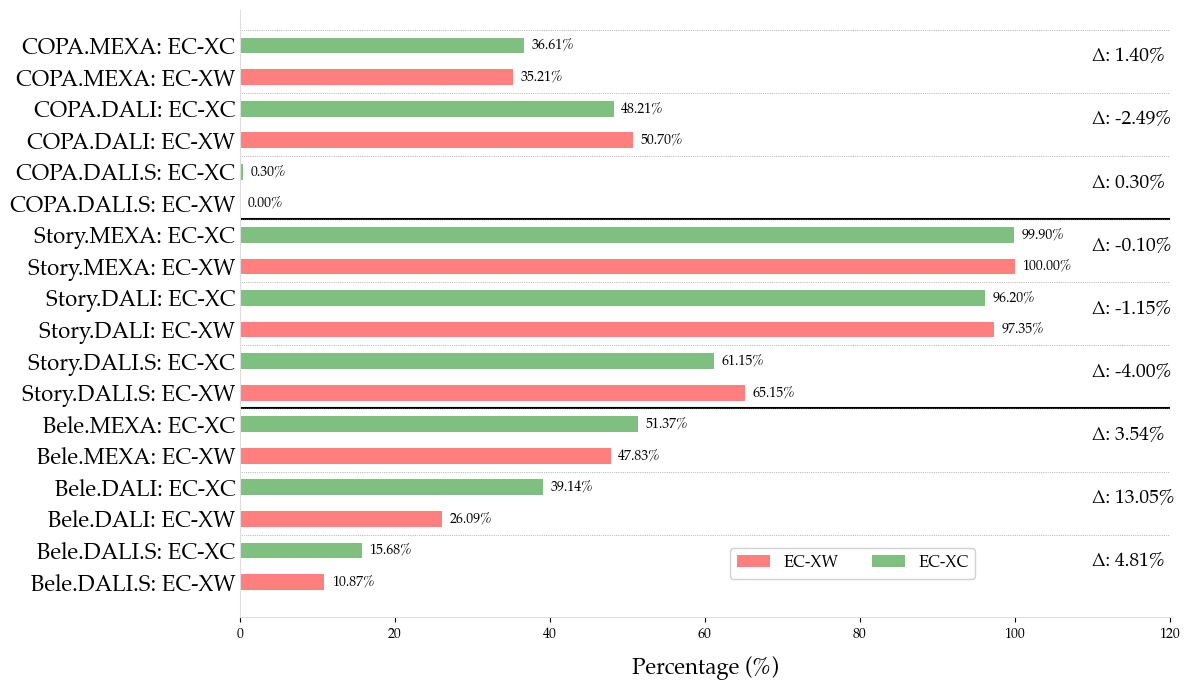

In [ ]:
# Define colors and hatch patterns
colors = ['red', 'green', 'red', 'green', 'red', 'green', 
          'red', 'green', 'red', 'green', 'red', 'green',
          'red', 'green', 'red', 'green', 'red', 'green'] 


categories = ['Bele.DALI.S: EC-XW', 'Bele.DALI.S: EC-XC', 'Bele.DALI: EC-XW', 'Bele.DALI: EC-XC', 'Bele.MEXA: EC-XW', 'Bele.MEXA: EC-XC',
              'Story.DALI.S: EC-XW', 'Story.DALI.S: EC-XC', 'Story.DALI: EC-XW', 'Story.DALI: EC-XC', 'Story.MEXA: EC-XW', 'Story.MEXA: EC-XC',
              'COPA.DALI.S: EC-XW', 'COPA.DALI.S: EC-XC', 'COPA.DALI: EC-XW', 'COPA.DALI: EC-XC', 'COPA.MEXA: EC-XW', 'COPA.MEXA: EC-XC',]

values = []
values.extend(belebele_values)
values.extend(xstorycloze_values)
values.extend(xcopa_values)


# Create a figure and axis object for more control
plt.figure(figsize=(12, 7))  # Slightly larger figure for better spacing

# Create the horizontal bar chart
bars = plt.barh(categories, values, color=colors, alpha=0.5, height=0.5)



# Annotate the bars with percentages
for bar in bars:
    plt.text(bar.get_width() + 1, bar.get_y() + bar.get_height() / 2,
             f'{bar.get_width():.2f}%', va='center', ha='left', fontsize=10)
    
# Add horizontal separator lines
plt.axhline(y=5.5, color='black', linestyle='-', linewidth=1.5)  # Between Belebele and Story
plt.axhline(y=11.5, color='black', linestyle='-', linewidth=1.5)  # Between Story and COPA

# Add dotted lines between rows

for i in range(1, 18, 2):
    plt.axhline(y=i+0.5, color='gray', linestyle=':', linewidth=0.5)
    plt.annotate(f'Δ: {(values[i]-values[i-1]):.2f}%',(110,i-0.5), size=14)

# Create custom legend
legend_elements = [
    Patch(facecolor='red', alpha=0.5, label='EC-XW'),
    Patch(facecolor='green', alpha=0.5, label='EC-XC')
]



# Add the legend with better positioning
plt.legend(handles=legend_elements, loc='lower right', bbox_to_anchor=(0.8, 0.05), 
           frameon=True, framealpha=0.9, fontsize=12, ncol=3)

# Clean up the formatting
plt.xlabel('Percentage (%)', fontsize=16, labelpad=10, color="black")
plt.yticks(fontsize=16)
plt.xlim(0, 120)  # Extend x-axis slightly to ensure text annotations fit





# Add subtle styling
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().tick_params(axis='y', length=0)  # Hide y-tick marks
plt.gca().spines['left'].set_color('#DDDDDD')
plt.gca().spines['bottom'].set_color('#DDDDDD')

# Improve overall layout
plt.tight_layout()
plt.savefig('/Users/kartik/Downloads/Images_DALI/sample_zh')
plt.show()